# Place SVG shapes into canvas given bounding boxes 

In [1]:
import json
import sys
import os
from PIL import Image, ImageDraw

In [2]:
# import the library
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

from svglib.svg import SVG
from svglib.geom import Point

In [3]:
def show(svg_img):
    white_bg = Image.new("RGBA", (128, 128), "WHITE")
    white_bg.paste(
        svg_img.draw(return_png=True, do_display=False), 
        (0, 0), 
        svg_img.draw(return_png=True, do_display=False)
        ) 
    white_bg.convert("RGB").show()

In [4]:
sample_dir = os.path.join(root_dir, "samples")
# a dict that tells you where to place a series of SVGs in a canvas 
coords = {
    "house_body": {
      "file": "square_lines.svg",
      "bounding_box": [20, 50, 100, 120]
    },
    "window_1": {
      "file": "square_lines.svg",
      "bounding_box": [35, 70, 55, 90]
    },
    "window_2": {
      "file": "square_lines.svg",
      "bounding_box": [70, 70, 90, 90]
    },
    "roof": {
      "file": "triangle.svg",
      "bounding_box": [20, 5, 100, 50]
    }
  }
  

## Destination Coordinates
We start from a series of SVG shapes and the bounding box of the location where each has to fit.

We draw each bounding box on a raster image to get an idea of where all the SVGs should go

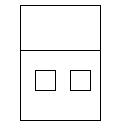

In [5]:
def draw_bboxes(coords):
    img = Image.new('RGB', (128, 128), color='white')
    draw = ImageDraw.Draw(img)
    for _, c in coords.items():
        x, y, x2, y2 = c['bounding_box']
        draw.rectangle([x, y, x2, y2], outline="black", fill=None)
    return img

draw_bboxes(coords)

## Scaling Factor
Each SVG should be scaled to fit its bounding box.

By defaul we consider the full size of each original SVG image (128, 128)

In [6]:
# let's take the first square, and scale it to fit its bounding box in the canvas
def compute_scale(x1, y1, x2, y2, orig_w=128, orig_h=128):
    new_w, new_h = (x2 - x1, y2 - y1)  # the size of the bounding box
    width_ratio = new_w / orig_w
    height_ratio = new_h / orig_h
    return width_ratio, height_ratio

(x1, y1, x2, y2) = coords["roof"]["bounding_box"]
width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
print(width_ratio, height_ratio)
scale_factor = min(width_ratio, height_ratio)


0.625 0.3515625


## display one SVG

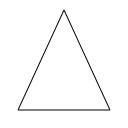

SVG[Bbox(0.0 0.0 128.0 128.0)](
	SVGLine(xy1=P(64.0, 10.0) xy2=P(110.0, 110.0)),
	SVGLine(xy1=P(110.0, 110.0) xy2=P(18.0, 110.0)),
	SVGLine(xy1=P(18.0, 110.0) xy2=P(64.0, 10.0))
)

In [7]:
svg_path = os.path.join(sample_dir, coords["roof"]["file"])
svg = SVG.load_svg(svg_path)
show(svg)
svg

## Scale and Shift
Since the scaling factors sx and sy between original image and destination bounding box
are not the same, we use minimum scale factor to avoid overflow.

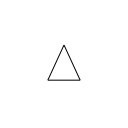

In [8]:
# scaling
svg.scale(scale_factor)
show(svg)

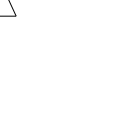

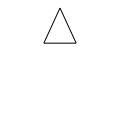

In [9]:
# let's adjust the shape so that the new center is the center of the bounding box
svg.translate(-svg.viewbox.center)
show(svg)

target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
svg.translate(target_center)
show(svg)


## Apply to all shapes and composite!

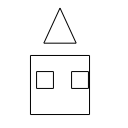

In [10]:
# apply this to every shape in the SVG file
composite = SVG([], (128, 128), width=128, height=128)

for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
    scale_factor = min(width_ratio, height_ratio)
    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.scale(scale_factor)
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
show(composite)

## Use both (sx, sy) to scale
That is not nice. Now we will use a scaling factor for each dimension, even if it stretches the final image.

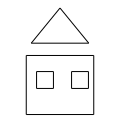

In [11]:
composite = SVG([], (128, 128), width=128, height=128)
for shape in coords.values():
    svg_path = os.path.join(sample_dir, shape["file"])
    svg = SVG.load_svg(svg_path)
    
    (x1, y1, x2, y2) = shape["bounding_box"]
    width_ratio, height_ratio = compute_scale(x1, y1, x2, y2)
    target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
    
    svg.scale((width_ratio, height_ratio))
    svg.translate(-svg.viewbox.center)
    svg.translate(target_center)
    composite = composite + svg 
    
show(composite)

## Use the bounding box of the shape
We inherit some padding from the original image!

Let's compute (sx, sy) using the bounding box that wraps each shape to get the best scaling ratio

In [12]:
svg.bbox()

((31.25, 8.015625), (88.75, 43.171875))

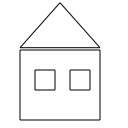

In [13]:
def composite(coords):
    composite = SVG([], (128, 128), width=128, height=128)
    for shape in coords.values():
        svg_path = os.path.join(sample_dir, shape["file"])
        svg = SVG.load_svg(svg_path)
        
        (x1, y1, x2, y2) = shape["bounding_box"]
        (_x1, _y1), (_x2, _y2) = svg.bbox()
        
        # compute width and height for the box rather than the full image
        _w, _h = _x2 - _x1, _y2 - _y1
        width_ratio, height_ratio = compute_scale(x1, y1, x2, y2, _w, _h)

        target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
        
        svg.scale((width_ratio, height_ratio))
        svg.translate(-svg.viewbox.center)
        svg.translate(target_center)
        composite = composite + svg 
    return composite

result = composite(coords)
show(result)

# More examples: A car

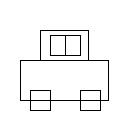

In [14]:
coords = {
    "car_body": {
        "file": "square_lines.svg",
        "bounding_box": [20, 60, 108, 100]  # Main car body
    },
    "car_top": {
        "file": "square_lines.svg",
        "bounding_box": [40, 30, 88, 60]  # Smaller top section (like a windshield/cabin)
    },
    "wheel_1": {
        "file": "circle.svg",
        "bounding_box": [30, 90, 50, 110]  # Left wheel
    },
    "wheel_2": {
        "file": "circle.svg",
        "bounding_box": [80, 90, 100, 110]  # Right wheel
    },
    "front_window": {
        "file": "square_lines.svg",
        "bounding_box": [50, 35, 65, 55]  # Front windshield
    },
    "rear_window": {
        "file": "square_lines.svg",
        "bounding_box": [65, 35, 80, 55]  # Rear windshield
    }
}
draw_bboxes(coords)


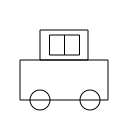

In [15]:
result = composite(coords)
show(result)

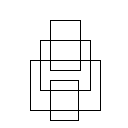

In [16]:
coords = {
    "trunk": {
        "file": "rect.svg",
        "bounding_box": [50, 80, 78, 120]  # Tall rectangle for the trunk
    },
    "foliage_bottom": {
        "file": "circle.svg",
        "bounding_box": [30, 60, 100, 110]  # Large bottom foliage
    },
    "foliage_middle": {
        "file": "circle.svg",
        "bounding_box": [40, 40, 90, 90]  # Middle foliage
    },
    "foliage_top": {
        "file": "circle.svg",
        "bounding_box": [50, 20, 80, 70]  # Smallest top foliage
    }
}
draw_bboxes(coords)


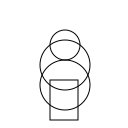

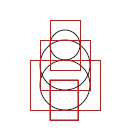

In [17]:
result = composite(coords)
show(result)

# Let's draw with the bounding boxes
img = Image.new("RGBA", (128, 128), "WHITE")
img.paste(
    result.draw(return_png=True, do_display=False), 
    (0, 0), 
    result.draw(return_png=True, do_display=False)
    ) 
img.convert("RGB")
draw = ImageDraw.Draw(img)
for _, c in coords.items():
    x, y, x2, y2 = c['bounding_box']
    draw.rectangle([x, y, x2, y2], outline="red", fill=None)
img.show()